In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import tabulate as tabulate
import requests
from geopy.distance import great_circle

# Importing and Data Wrangling

In [3]:
bike_master = pd.read_csv('bike_full.csv', dtype={5: str, 7: str})  # Convert both columns to strings


In [4]:
bike_hourly = pd.read_csv('hourly_weather.csv')

In [5]:
bike_master_clean = bike_master.copy()

# Convert datetime columns
bike_master_clean['started_at'] = pd.to_datetime(bike_master_clean['started_at'])
bike_master_clean['ended_at'] = pd.to_datetime(bike_master_clean['ended_at'])

# Convert category columns
category_columns = ['rideable_type', 'start_station_name', 'end_station_name', 'member_casual']
for col in category_columns:
    bike_master_clean[col] = bike_master_clean[col].astype('category')

# Convert string columns (IDs)
string_columns = ['ride_id', 'start_station_id', 'end_station_id']
for col in string_columns:
    bike_master_clean[col] = bike_master_clean[col].astype('string')

In [6]:
#create a copy of the bike hourly data
bike_hourly_new = bike_hourly.copy()

# Convert the 'Date' column to datetime
bike_hourly_new['Date'] = pd.to_datetime(bike_hourly_new['Date'])

# Ensure 'Hour' is integer (if it's not already)
bike_hourly_new['Hour'] = bike_hourly_new['Hour'].astype(int)

# Convert float columns correctly
float_columns = ['Casual', 'Member', 'Total_rides', 'temperature_2m (°C)', 'windspeed_10m (km/h)']
bike_hourly_new[float_columns] = bike_hourly_new[float_columns].astype(float)

# Convert integer columns
int_columns = ['relativehumidity_2m (%)', 'weathercode (wmo code)']
bike_hourly_new[int_columns] = bike_hourly_new[int_columns].astype(int)

#adding month_year as a column
bike_hourly_new['month_year'] = bike_hourly_new['Date'].dt.strftime('%Y-%m')

#convert month year to datetime
bike_hourly_new['month_year'] = pd.to_datetime(bike_hourly_new['month_year'])

#have a year column
bike_hourly_new['year'] = bike_hourly_new['Date'].dt.year

# Check the updated data types
print(bike_hourly_new.dtypes)

#change the columns to lowercase and remove spaces
bike_hourly_new.columns = bike_hourly_new.columns.str.lower().str.replace(' ', '_')
bike_hourly_new.head()


Casual                            float64
Date                       datetime64[ns]
Hour                                int64
Member                            float64
Total_rides                       float64
relativehumidity_2m (%)             int64
temperature_2m (°C)               float64
weathercode (wmo code)              int64
windspeed_10m (km/h)              float64
month_year                 datetime64[ns]
year                                int32
dtype: object


,casual,date,hour,member,total_rides,relativehumidity_2m_(%),temperature_2m_(°c),weathercode_(wmo_code),windspeed_10m_(km/h),month_year,year
0,20.0,2021-01-01,0,26.0,46.0,90,2.4,1,10.2,2021-01-01,2021
1,23.0,2021-01-01,1,23.0,46.0,88,1.8,1,10.0,2021-01-01,2021
2,20.0,2021-01-01,2,28.0,48.0,87,1.1,2,10.1,2021-01-01,2021
3,9.0,2021-01-01,3,7.0,16.0,81,1.6,2,10.6,2021-01-01,2021
4,7.0,2021-01-01,4,5.0,12.0,77,1.6,2,9.9,2021-01-01,2021


In [7]:
#finding null values
bike_master_clean.isnull().sum()


ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      811282
end_station_id        811282
start_lat                  2
start_lng                  2
end_lat                16765
end_lng                16765
member_casual              0
dtype: int64

In [8]:
#finding unique values for few columns
bike_master_clean[['start_station_name', 'end_station_name', 'start_station_id', 'end_station_id','start_lat']].nunique()

start_station_name       860
end_station_name         865
start_station_id        1321
end_station_id          1338
start_lat             570110
dtype: int64

In [9]:
#create a new column for month year
bike_master_clean['month_year'] = bike_master_clean['started_at'].dt.to_period('M')

#create a new column for year
bike_master_clean['year'] = bike_master_clean['started_at'].dt.year

#create a new dataframe for the month june 2023 to december 2023
bike_master_clean_2023 = bike_master_clean[(bike_master_clean['year'] == 2023)]

row_count = len(bike_master_clean_2023)
print(f"Number of rows in the dataset: {row_count}")

Number of rows in the dataset: 4467334


In [10]:
#find missing null values
print(bike_master_clean_2023.isnull().sum())

#drop missing values
bike_master_clean_2023 = bike_master_clean_2023.dropna()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    406630
start_station_id      406630
end_station_name      432484
end_station_id        432484
start_lat                  0
start_lng                  0
end_lat                 5945
end_lng                 5945
member_casual              0
month_year                 0
year                       0
dtype: int64


# EDA and Plotting 

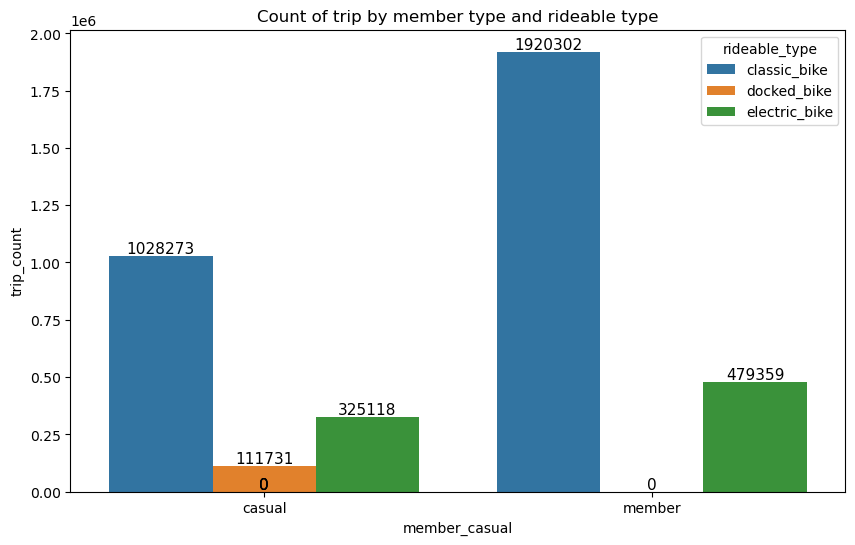

In [11]:
#Count of trip by member type and rideable type by ride id
member_rideable = (
    bike_master_clean_2023
    .groupby(['member_casual', 'rideable_type'], observed=False)
    .agg(trip_count=('ride_id', 'count'))
    .reset_index()
)

#plotting the count of trip by member type and rideable type
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='member_casual', y='trip_count', hue='rideable_type', data=member_rideable)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Count of trip by member type and rideable type')
plt.show()


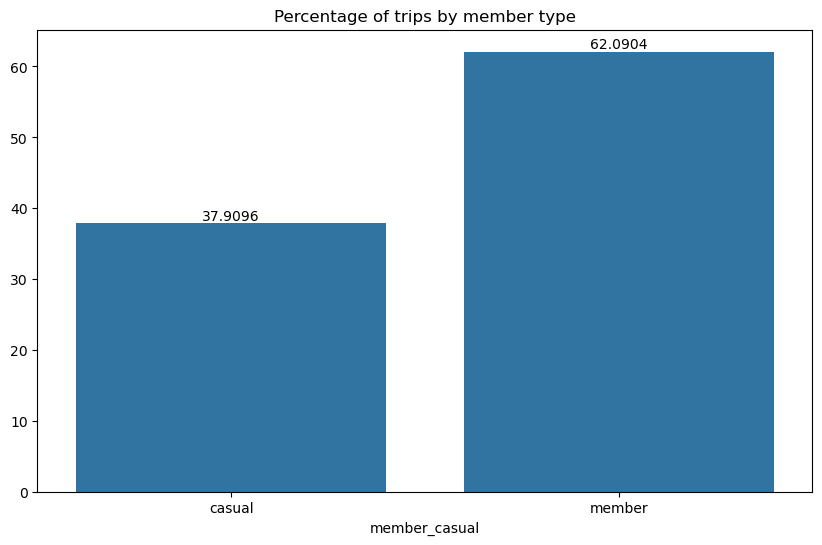

In [12]:
#calculating the num  of trips by member type
trip_counts = bike_master_clean_2023['member_casual'].value_counts()

#calculating the percentage of trips by member type
trip_percent = (trip_counts / trip_counts.sum()) * 100

trip_percent

#plotting the percentage of trips by member type
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=trip_percent.index, y=trip_percent.values)
ax.bar_label(ax.containers[0])
plt.title('Percentage of trips by member type')
plt.show()


In [13]:
#calculate the average duration of trips by member type

bike_master_clean_2023['duration'] = (bike_master_clean_2023['ended_at'] - bike_master_clean_2023['started_at']).dt.total_seconds() / 60

#group by member type and calculate the average duration
avg_duration = (
    bike_master_clean_2023
    .groupby('member_casual', observed=False)
    .agg(avg_duration=('duration', 'mean'))
    .reset_index()
)

avg_duration

,member_casual,avg_duration
0,casual,28.179683
1,member,12.795157


In [14]:
# Function to categorize stations
def categorize_station_location(lat, lng):
    regions = {
        'Washington DC': {'lat': (38.8, 39.0), 'lng': (-77.12, -76.9)},
        'Arlington': {'lat': (38.8, 38.93), 'lng': (-77.17, -77.03)},
        'Alexandria': {'lat': (38.77, 38.85), 'lng': (-77.15, -77.03)},
        'Montgomery County': {'lat': (38.95, 39.2), 'lng': (-77.3, -76.9)},
        "Prince George's County": {'lat': (38.8, 39.1), 'lng': (-76.95, -76.7)},
        'Fairfax County': {'lat': (38.7, 39.0), 'lng': (-77.4, -77.15)}
    }
    
    for region, bounds in regions.items():
        if (bounds['lat'][0] <= lat <= bounds['lat'][1] and 
            bounds['lng'][0] <= lng <= bounds['lng'][1]):
            return region
    return 'Other'

# Apply function to classify each start station
bike_master_clean_2023['region'] = bike_master_clean_2023.apply(lambda row: categorize_station_location(row['start_lat'], row['start_lng']), axis=1)

rideable_type             classic_bike  docked_bike  electric_bike
member_casual month_year                                          
casual        2023-01        80.692666    11.505928       7.801406
              2023-02        79.232897    10.800268       9.966834
              2023-03        75.488542    12.912231      11.599227
              2023-04        67.000302    12.021186      20.978512
              2023-05        68.285318    10.210936      21.503746
              2023-06        70.862804    10.119652      19.017543
              2023-07        71.088499     9.999492      18.912009
              2023-08        69.238060     9.056499      21.705441
              2023-09        73.862082     3.199563      22.938354
              2023-10        69.640946     0.000000      30.359054
              2023-11        63.628869     0.000000      36.371131
              2023-12        58.052512     0.000000      41.947488
member        2023-01        93.423557     0.000000       6.57

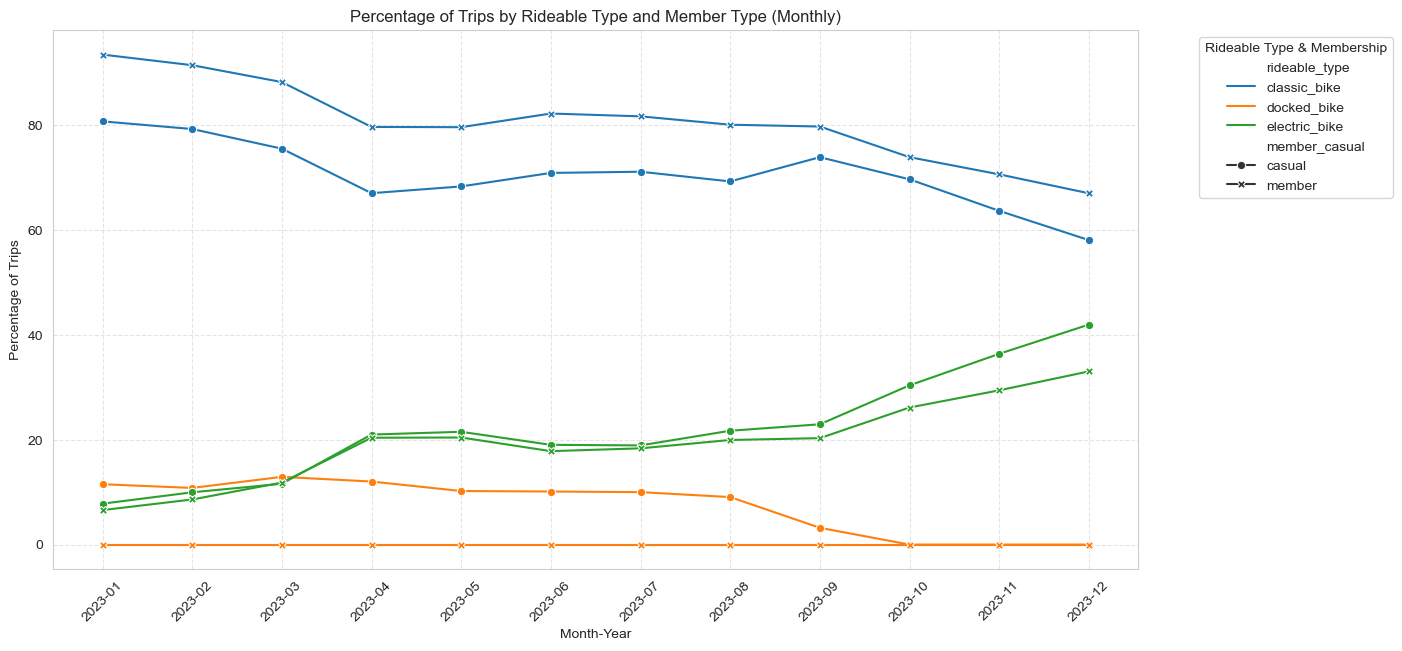

In [15]:
# Group by month and rideable type, then count trips
monthly_rideable_type = bike_master_clean_2023.groupby(['member_casual','month_year', 'rideable_type'],observed=False).size().unstack(fill_value=0)

# Calculate percentage of trips by rideable type per month
monthly_rideable_type_percent = (monthly_rideable_type.div(monthly_rideable_type.sum(axis=1), axis=0)) * 100

# Display result
print(monthly_rideable_type_percent)


# Set Seaborn style
sns.set_style("whitegrid")

# Convert month_year to string for plotting
monthly_rideable_type_percent = monthly_rideable_type_percent.reset_index()
monthly_rideable_type_percent['month_year'] = monthly_rideable_type_percent['month_year'].astype(str)

# Create line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_rideable_type_percent.melt(id_vars=['member_casual', 'month_year'], var_name='rideable_type', value_name='percentage'),
    x="month_year", 
    y="percentage", 
    hue="rideable_type", 
    style="member_casual", 
    markers=True, 
    dashes=False
)

# Labels and Title
plt.ylabel("Percentage of Trips")
plt.xlabel("Month-Year")
plt.title("Percentage of Trips by Rideable Type and Member Type (Monthly)")
plt.xticks(rotation=45)
plt.legend(title="Rideable Type & Membership", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

rideable_type             classic_bike  docked_bike  electric_bike
member_casual month_year                                          
casual        2021-01        53.338126    13.792794      32.869081
              2021-02        51.089832    11.587082      37.323086
              2021-03        57.073474    19.205325      23.721201
              2021-04        56.736447    19.518124      23.745430
              2021-05        56.885030    18.380251      24.734719
...                                ...          ...            ...
member        2023-08        68.362692     0.000000      31.637308
              2023-09        67.104817     0.000000      32.895183
              2023-10        60.275382     0.000000      39.724618
              2023-11        55.711748     0.000000      44.288252
              2023-12        50.813429     0.000000      49.186571

[72 rows x 3 columns]


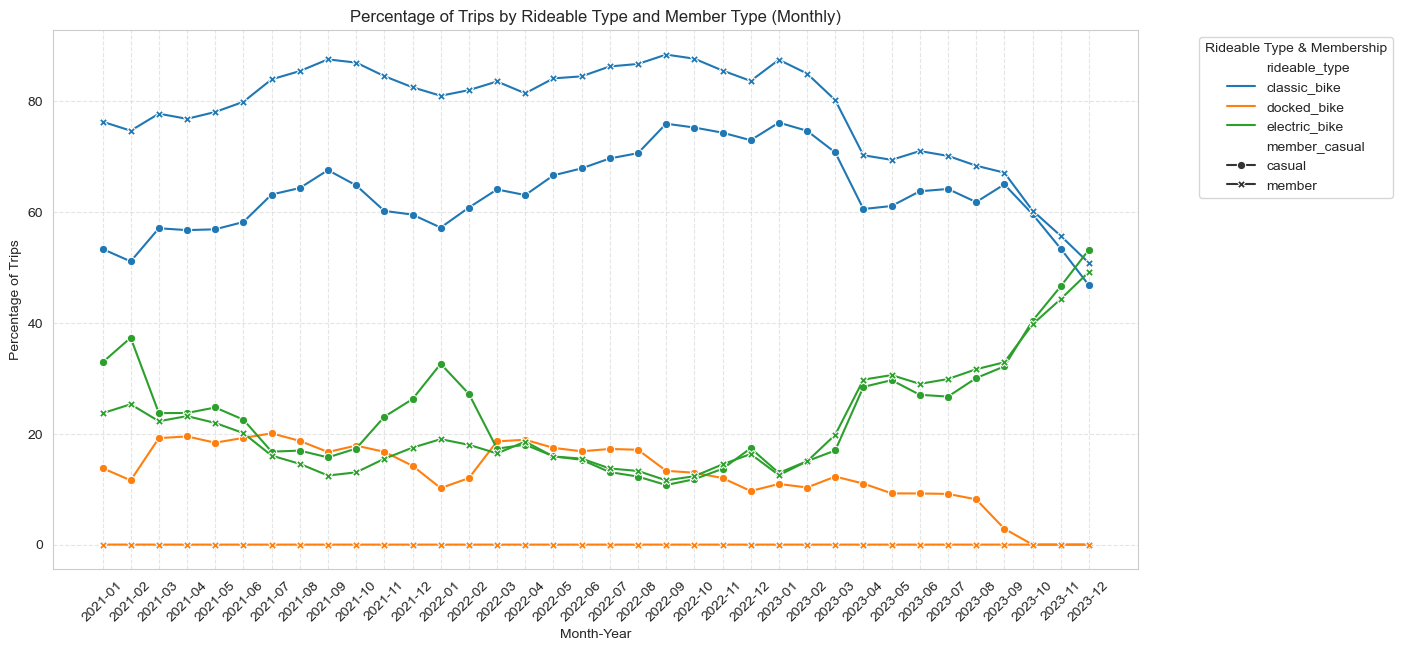

In [16]:
# Group by month and rideable type, then count trips
monthly_rideable_type = bike_master_clean.groupby(['member_casual','month_year', 'rideable_type'],observed=False).size().unstack(fill_value=0)

# Calculate percentage of trips by rideable type per month
monthly_rideable_type_percent = (monthly_rideable_type.div(monthly_rideable_type.sum(axis=1), axis=0)) * 100

# Display result
print(monthly_rideable_type_percent)


# Set Seaborn style
sns.set_style("whitegrid")

# Convert month_year to string for plotting
monthly_rideable_type_percent = monthly_rideable_type_percent.reset_index()
monthly_rideable_type_percent['month_year'] = monthly_rideable_type_percent['month_year'].astype(str)

# Create line plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=monthly_rideable_type_percent.melt(id_vars=['member_casual', 'month_year'], var_name='rideable_type', value_name='percentage'),
    x="month_year", 
    y="percentage", 
    hue="rideable_type", 
    style="member_casual", 
    markers=True, 
    dashes=False
)

# Labels and Title
plt.ylabel("Percentage of Trips")
plt.xlabel("Month-Year")
plt.title("Percentage of Trips by Rideable Type and Member Type (Monthly)")
plt.xticks(rotation=45)
plt.legend(title="Rideable Type & Membership", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

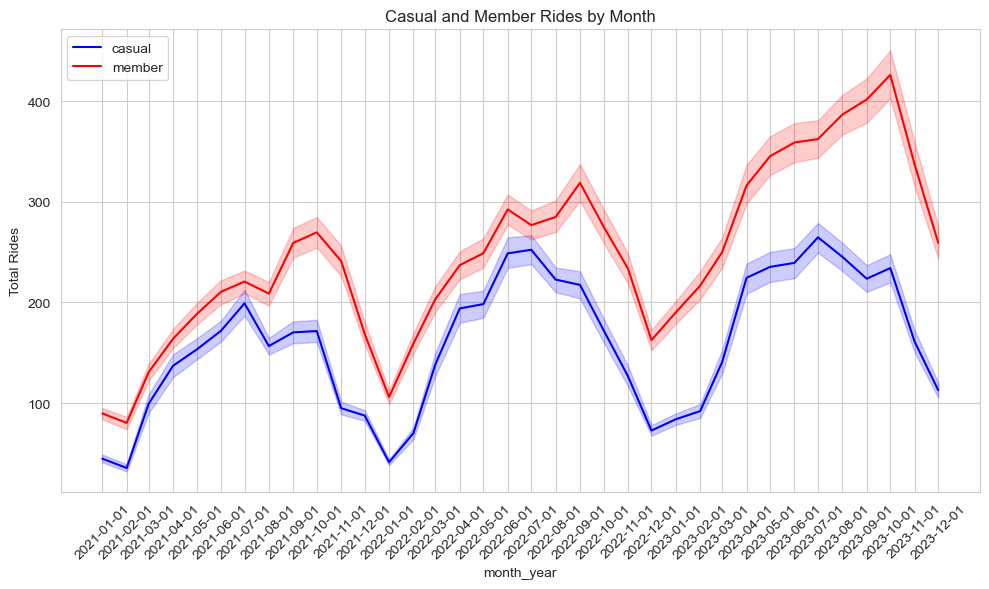

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='casual', data=bike_hourly_new, label='casual', color='blue')
sns.lineplot(x='month_year', y='member', data=bike_hourly_new, label='member', color='red')
plt.xticks(rotation=45)
plt.xticks(ticks=bike_hourly_new['month_year'].unique())  # Show all months explicitly
plt.title('Casual and Member Rides by Month')
plt.ylabel('Total Rides')
plt.tight_layout()
plt.show()

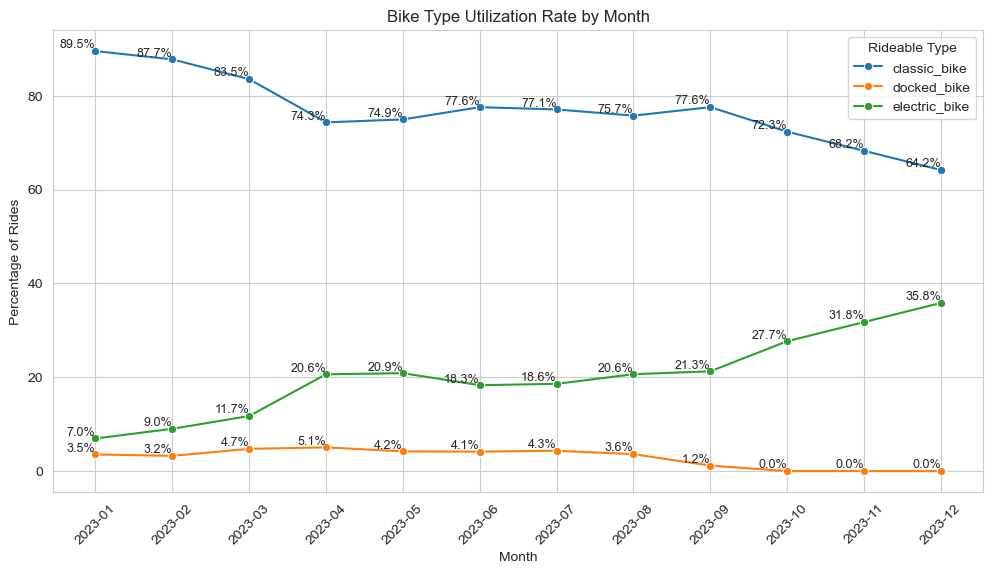

In [18]:
#Bike Type Utilization Rate in percentage by  Monthly and by User Type, Helps in understanding the popularity of different bike types and optimizing inventory.

#count the ride per rideable type and month
rideable_type_monthly = bike_master_clean_2023.groupby(['month_year', 'rideable_type'], observed=False).agg(trip_count=('ride_id', 'count')).reset_index()

#calculate the total number of rides per month
total_rides = rideable_type_monthly.groupby('month_year', observed=False).agg(total_rides=('trip_count', 'sum')).reset_index()

# Merge total rides with bike type counts
rideable_type_monthly = rideable_type_monthly.merge(total_rides, on='month_year', how='left')

# Calculate percentage of rides per bike type
rideable_type_monthly['percentage'] = (rideable_type_monthly['trip_count'] / rideable_type_monthly['total_rides']) * 100

# Convert month_year to string for plotting
rideable_type_monthly['month_year'] = rideable_type_monthly['month_year'].astype(str)

#plot the percentage of rides per bike type
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=rideable_type_monthly, x='month_year', y='percentage', hue='rideable_type', marker='o')

# Annotate each point with its percentage value
for line in ax.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        ax.text(x_value, y_value, f"{y_value:.1f}%", ha='right', va='bottom', fontsize=9)

plt.title("Bike Type Utilization Rate by Month")
plt.xlabel("Month")
plt.ylabel("Percentage of Rides")
plt.xticks(rotation=45)
plt.legend(title="Rideable Type")
plt.grid(True)
plt.show()




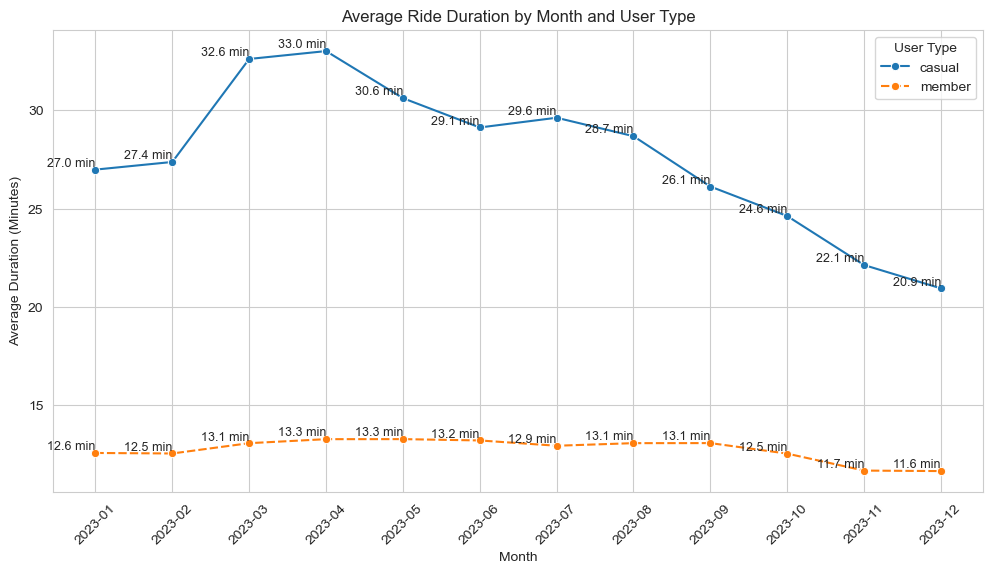

In [19]:
#Average Ride Duration: Monthly and by User Type , Helps in understanding the typical ride length and optimizing pricing or availability.
# Convert 'started_at' to string format 'YYYY-MM' for grouping
bike_master_clean_2023['started_at_month'] = bike_master_clean_2023['started_at'].dt.strftime('%Y-%m')

# Group by the new string column and 'member_casual'
avg_duration_monthly = bike_master_clean_2023.groupby(['started_at_month', 'member_casual'], observed=False)['duration'].mean().unstack()
avg_duration_monthly

#plot the average ride duration by month and user type
plt.figure(figsize=(12, 6))
ax =sns.lineplot(data=avg_duration_monthly, marker='o')
for line in ax.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        ax.text(x_value, y_value, f"{y_value:.1f} min", ha='right', va='bottom', fontsize=9)

plt.title("Average Ride Duration by Month and User Type")
plt.xlabel("Month")
plt.ylabel("Average Duration (Minutes)")
plt.xticks(rotation=45)
plt.legend(title="User Type")
plt.grid(True)
plt.show()


In [20]:
#load one day data
# Ensure bike_master_clean_2023 is loaded
bike_master_clean_2023["started_at"] = pd.to_datetime(bike_master_clean_2023["started_at"])
one_day = bike_master_clean_2023[bike_master_clean_2023["started_at"].dt.date == pd.to_datetime("2023-01-31").date()].copy()


# Fetch live JSON data for free bikes
url = "https://gbfs.lyft.com/gbfs/2.3/dca-cabi/en/free_bike_status.json"
response = requests.get(url)
free_bike_data = response.json()

# Extract available bikes
free_bikes = pd.DataFrame(free_bike_data["data"]["bikes"])

# Convert to numeric lat/lng
free_bikes["lat"] = free_bikes["lat"].astype(float)
free_bikes["lon"] = free_bikes["lon"].astype(float)

# Debug: Print dataset sizes
print(f"Total rides on 31-01-2023: {one_day.shape[0]}")
print(f"Total free bikes: {free_bikes.shape[0]}")

# Function to find nearest available bike within 1000m
def find_nearest(lat, lon, free_bikes):
    if free_bikes.empty:
        return None
    distances = free_bikes.apply(lambda x: great_circle((lat, lon), (x["lat"], x["lon"])).meters, axis=1)
    nearest_idx = distances.idxmin() if not distances.empty else None
    return free_bikes.loc[nearest_idx, "bike_id"] if nearest_idx is not None and distances.min() < 1000 else None  # Increased to 1000m

# Apply nearest match for available bikes
one_day.loc[:, "nearest_bike_id"] = one_day.apply(lambda row: find_nearest(row["start_lat"], row["start_lng"], free_bikes), axis=1)

# Calculate utilization (1 if a bike is found near the station, else 0)
one_day.loc[:, "utilization_rate"] = one_day["nearest_bike_id"].notnull().astype(int)

# Debug: Print stations with no matches
unmatched_stations = one_day[one_day["nearest_bike_id"].isnull()]["start_station_name"].unique()
print(f"Stations with no available bikes: {len(unmatched_stations)}")
print(unmatched_stations[:10])  # Show first 10 unmatched stations

# Aggregate at the station level
region_utilization = one_day.groupby("start_station_name")["utilization_rate"].mean().reset_index()
region_utilization.rename(columns={"utilization_rate": "utilization_rate_avg"}, inplace=True)

Total rides on 31-01-2023: 4505
Total free bikes: 1135
Stations with no available bikes: 19
['The Shoppes @ Burnt Mills', '15th St & Massachusetts Ave SE', 'Reston YMCA', 'Long Bridge Aquatic Center', 'South Gate Community Center', 'Park Run & Onyx Dr', 'Ridge Heights and Owl Cove Ln', 'Largo Town Center Metro', '15th & East Capitol St NE', 'Wisconsin Ave & Newark St NW']
Categories (860, object): ['10th & E St NW', '10th & Florida Ave NW', '10th & G St NW', '10th & H St NE', ..., 'Woodley Park Metro / Calvert St & Connecticut..., 'Woodmont Ave & Strathmore St', 'Woody Ward Rec Center', 'Yuma St & Tenley Circle NW']


/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_81414/2659659889.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_utilization = one_day.groupby("start_station_name")["utilization_rate"].mean().reset_index()


In [21]:
# Define the center of the map (Washington, D.C.)
map_center = [38.89511, -77.03637]

# Create a folium map
no_avail_map = folium.Map(location=map_center, zoom_start=12)

# Add GeoJSON layer
folium.GeoJson("Neighborhood_Planning_Areas.geojson").add_to(no_avail_map)

# Filter for stations with no available bikes
no_avail_stations = one_day[one_day["nearest_bike_id"].isnull()]

# Add no-availability stations to the map
for index, row in no_avail_stations.iterrows():
    folium.Marker(
        location=[row["start_lat"], row["start_lng"]],
        popup=f"Station: {row['start_station_name']}<br>No Available Bikes",
        icon=folium.Icon(color="red", icon="times-circle", prefix="fa"),  # Red icon for no availability
    ).add_to(no_avail_map)

# Display the map
no_avail_map


In [22]:
#importing new csv file
bus_stations = pd.read_csv('Metro_Bus_Stops.csv') # Metro bus stations
bike_stations = pd.read_csv('Capital_Bikeshare_Locations.csv')  # Capital Bikeshare stations

#change the header name to lowercase and remove spaces
bus_stations.columns = bus_stations.columns.str.lower().str.replace(' ', '_')
bike_stations.columns = bike_stations.columns.str.lower().str.replace(' ', '_')



In [23]:
# Convert 'started_at' to date only
bike_master_clean_2023['date'] = bike_master_clean_2023['started_at'].dt.date

# Specify the date for which you want to calculate departures (convert to date type)
specific_date = pd.to_datetime('2023-02-03').date()

# Filter the dataset for the specific date
filtered_data = bike_master_clean_2023[bike_master_clean_2023['date'] == specific_date]

# Ensure num_bikes_available is numeric
bike_stations['num_bikes_available'] = pd.to_numeric(bike_stations['num_bikes_available'], errors='coerce')

# Count trips per start station using trip ID
trip_count = filtered_data.groupby('start_station_name')['ride_id'].count().reset_index()

# Rename the column for clarity
trip_count.rename(columns={'ride_id': 'trip_count'}, inplace=True)

# Merge with the station data
station_departure = trip_count.merge(bike_stations, left_on='start_station_name', right_on='name')

# Calculate the utilization rate of the stations
station_departure['utilization_rate'] = station_departure['trip_count'] / station_departure['num_bikes_available']

# Display the top 10 stations with the highest utilization rate
top_10_departure = station_departure.nlargest(10, 'utilization_rate')
top_10_departure

# Show only station name, trip count, and utilization rate
top_10_departure = top_10_departure[['start_station_name', 'latitude', 'longitude', 'trip_count', 'num_bikes_available', 'utilization_rate']]   
top_10_departure

# Create a base map centered around Washington, D.C.
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12)

# Define color categories based on utilization rate
def get_marker_color(utilization_rate):
    if utilization_rate == float('inf'):  # Critical places with no available bikes
        return 'red'
    elif utilization_rate > 5:  # High utilization
        return 'orange'
    elif utilization_rate > 1:  # Moderate utilization
        return 'blue'
    else:  # Underutilized
        return 'green'

# Create a marker cluster for better visualization
marker_cluster = MarkerCluster().add_to(m)

# Iterate over the data to add markers
for index, row in station_departure.iterrows():
    lat, lng = row['latitude'], row['longitude']
    station_name = row['start_station_name']
    trip_count_val = row['trip_count']
    num_bikes = row['num_bikes_available']
    utilization = row['utilization_rate']
    color = get_marker_color(utilization)

    popup_text = f"""
    <b>{station_name}</b><br>
    Trips: {trip_count_val}<br>
    Bikes Available: {num_bikes}<br>
    Utilization Rate: {utilization}
    """
    
    folium.Marker(
        location=[lat, lng],
        popup=popup_text,
        icon=folium.Icon(color=color)
    ).add_to(marker_cluster)

m


/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_81414/3829142286.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_count = filtered_data.groupby('start_station_name')['ride_id'].count().reset_index()
